## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## 2. Load Dataset and Define Variables
Here we define the treatment (`z`), outcome (`y`), and covariates. We also prepare the design matrix `X` and fit an OLS model.

In [ ]:
# Load the dataset
df = pd.read_csv('data.csv')

# Step 1: Define treatment, outcome, and covariates
treatment = 'z'
outcome = 'y'

# Exclude treatment, outcome, and any non-covariate columns (like 'school_id')
covariates = [col for col in df.columns if col not in [treatment, outcome, 'school_id']]

# Step 2: Prepare X and y for regression
X = df[[treatment] + covariates]
X = X.apply(pd.to_numeric, errors='coerce')  # Ensure all numeric
X = sm.add_constant(X)  # Add intercept
y = pd.to_numeric(df[outcome], errors='coerce')

# Step 3: Fit the linear regression model
model = sm.OLS(y, X).fit()

# Step 4: Extract treatment effect
ate = model.params[treatment]
conf_int = model.conf_int().loc[treatment]
p_value = model.pvalues[treatment]

# Step 5: Print results
print("Average Treatment Effect (ATE):", round(ate, 3))
print("95% Confidence Interval:", [round(conf_int[0], 3), round(conf_int[1], 3)])
print("P-value:", round(p_value, 4))


Average Treatment Effect (ATE): 0.413
95% Confidence Interval: [np.float64(0.388), np.float64(0.438)]
P-value: 0.0


**Interpretation:**
The coefficient of the treatment variable from the linear regression represents the estimated Average Treatment Effect (ATE). If the p-value is below 0.05, it suggests statistical significance.

## 3. School-Level Treatment Effects
This section compares the average outcome between treated and control groups within each school.

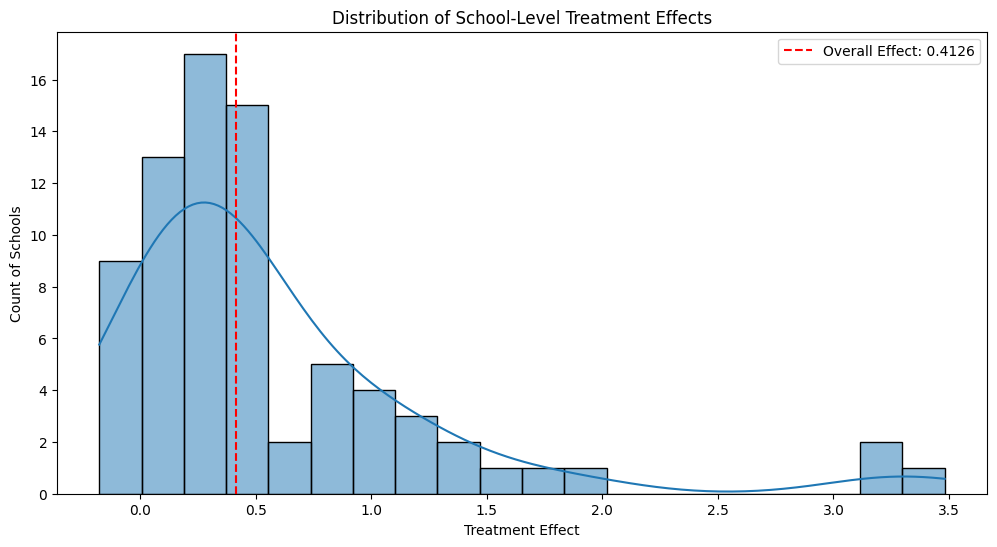

In [ ]:
import seaborn as sns
# School-level treatment effects
school_effects = df.groupby(['schoolid', 'z'])['y'].mean().reset_index()
# Make sure we have both treatment groups for each school
school_counts = df.groupby('schoolid')['z'].value_counts().unstack().fillna(0)
if 0 in school_counts.columns and 1 in school_counts.columns:
    schools_with_both = school_counts.index[(school_counts[0] > 0) & (school_counts[1] > 0)]

    school_effects_filtered = school_effects[school_effects['schoolid'].isin(schools_with_both)]
    if not school_effects_filtered.empty:
        school_effects_wide = school_effects_filtered.pivot(index='schoolid', columns='z', values='y')
        if 0 in school_effects_wide.columns and 1 in school_effects_wide.columns:
            school_effects_wide['effect'] = school_effects_wide[1] - school_effects_wide[0]

            plt.figure(figsize=(12, 6))
            sns.histplot(school_effects_wide['effect'], bins=20, kde=True) # sns is now defined and can be used
            plt.axvline(x=ate, color='r', linestyle='--', # Assuming treatment_effect should be the overall ATE
                      label=f'Overall Effect: {ate:.4f}') # Using ate for the overall effect
            plt.title('Distribution of School-Level Treatment Effects')
            plt.xlabel('Treatment Effect')
            plt.ylabel('Count of Schools')
            plt.legend()
            plt.show()
        else:
            print("Not enough data to calculate school-level effects")
    else:
        print("Not enough schools with both treatment and control to plot distribution of effects")
else:
    print("Unable to calculate school-level effects due to data structure")

**Interpretation:**
The histogram shows how treatment effects vary across schools. If the distribution is wide, it implies treatment impact is heterogeneous.

## 4. Estimate Treatment Effect using Inverse Probability Weighting (IPW)
Logistic regression is used to compute propensity scores, then a weighted regression is run to estimate the ATE.

IPW ATE: 0.414
95% CI: [np.float64(0.389), np.float64(0.439)]
P-value: 0.0


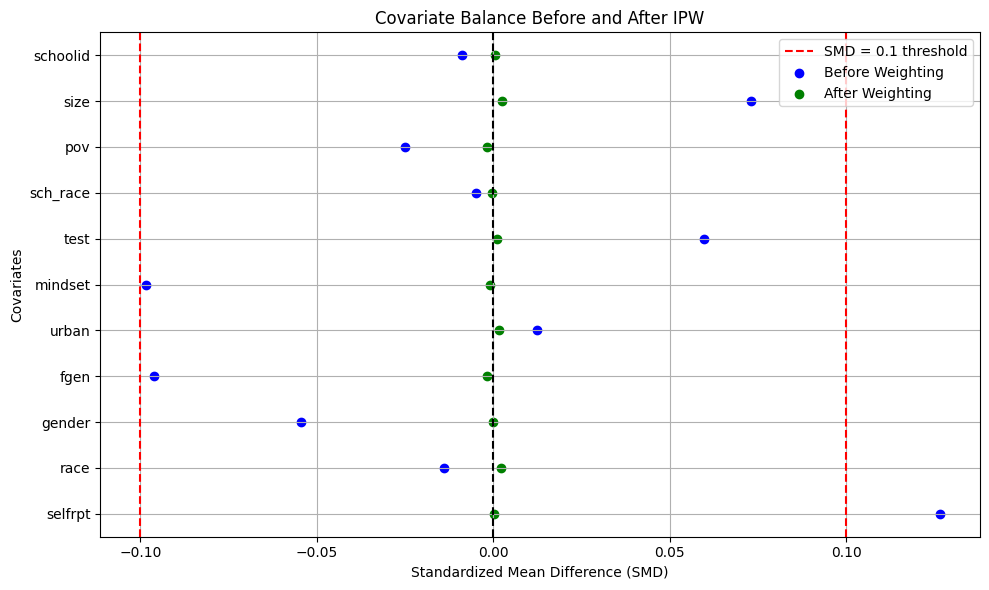

In [ ]:
# Step 1: Estimate Propensity Score (P(Z=1 | covariates))
X_cov = df[covariates]
X_cov = X_cov.apply(pd.to_numeric, errors='coerce')

prop_model = LogisticRegression(max_iter=1000)
prop_model.fit(X_cov, df[treatment])
propensity_score = prop_model.predict_proba(X_cov)[:, 1]

# Step 2: Calculate weights
df['weights'] = np.where(df[treatment] == 1,
                         1 / propensity_score,
                         1 / (1 - propensity_score))

# Step 3: Fit weighted regression model
X_full = df[[treatment] + covariates]
X_full = X_full.apply(pd.to_numeric, errors='coerce')
X_full = sm.add_constant(X_full)
y = pd.to_numeric(df[outcome], errors='coerce')
weights = df['weights']

model_ipw = sm.WLS(y, X_full, weights=weights).fit()

# Step 4: Get treatment effect estimate
ate_ipw = model_ipw.params[treatment]
conf_ipw = model_ipw.conf_int().loc[treatment]
pval_ipw = model_ipw.pvalues[treatment]

print("IPW ATE:", round(ate_ipw, 3))
print("95% CI:", [round(conf_ipw[0], 3), round(conf_ipw[1], 3)])
print("P-value:", round(pval_ipw, 4))

# --- Calculate SMDs before and after weighting ---
def compute_smd(data, covariate, treatment_col, weights=None):
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]

    if weights is not None:
        treat_mean = np.average(treated[covariate], weights=treated[weights])
        control_mean = np.average(control[covariate], weights=control[weights])
        treat_var = np.average((treated[covariate] - treat_mean)**2, weights=treated[weights])
        control_var = np.average((control[covariate] - control_mean)**2, weights=control[weights])
    else:
        treat_mean = treated[covariate].mean()
        control_mean = control[covariate].mean()
        treat_var = treated[covariate].var()
        control_var = control[covariate].var()

    pooled_std = np.sqrt((treat_var + control_var) / 2)
    smd = (treat_mean - control_mean) / pooled_std
    return smd

smd_unweighted = [compute_smd(df, cov, treatment) for cov in covariates]
smd_weighted = [compute_smd(df, cov, treatment, weights='weights') for cov in covariates]
# --- End of SMD calculation ---

# Step 5: Plot SMDs before and after weighting
plt.figure(figsize=(10, 6))
plt.axvline(0, color='black', linestyle='--')
plt.axvline(0.1, color='red', linestyle='--', label='SMD = 0.1 threshold')
plt.axvline(-0.1, color='red', linestyle='--')

plt.scatter(smd_unweighted, covariates, label='Before Weighting', color='blue')
plt.scatter(smd_weighted, covariates, label='After Weighting', color='green')

plt.xlabel('Standardized Mean Difference (SMD)')
plt.ylabel('Covariates')
plt.title('Covariate Balance Before and After IPW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 Each dot is a covariate.

Blue = before weighting (raw difference).

Green = after weighting (adjusted).

If green dots are close to zero and within ±0.1 range, you’ve balanced the covariates well.

**Interpretation:**
IPW helps control for confounding by reweighting observations. A small p-value indicates significant effect after adjusting for covariates.

## 5. Propensity Score Matching (PSM)
Match treated units to the nearest control based on propensity score. ATE is estimated from matched pairs.

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Step 1: Propensity score model
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(df[covariates], df[treatment])
df['prop_score'] = ps_model.predict_proba(df[covariates])[:, 1]

# Step 2: Match using Nearest Neighbors
treated = df[df[treatment] == 1]
control = df[df[treatment] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['prop_score']])
distances, indices = nn.kneighbors(treated[['prop_score']])

matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)

# Step 3: Estimate ATE
ate_matched = (matched_treated[outcome] - matched_control[outcome]).mean()
print("PSM ATE:", round(ate_matched, 3))

PSM ATE: 0.427


**Interpretation:**
PSM reduces bias by creating comparable groups. The reported ATE shows the average difference in outcomes across matched units.

## 6. Outcome Distribution After Matching
Visualize the distribution of the outcome variable for treated and matched control groups.

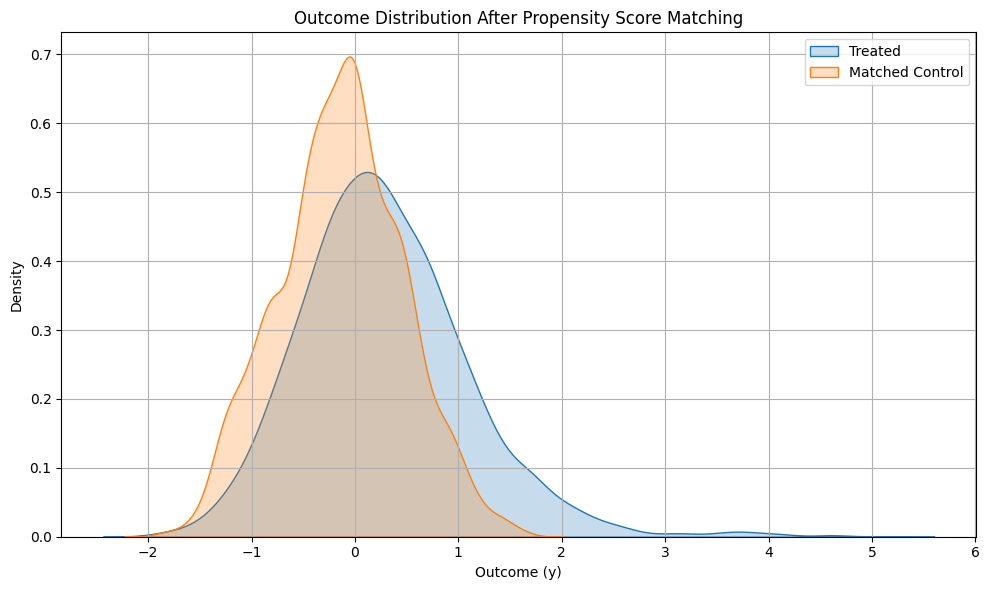

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# KDE plot of outcome for matched treated and matched control
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_treated[outcome], label="Treated", fill=True)
sns.kdeplot(matched_control[outcome], label="Matched Control", fill=True)
plt.title("Outcome Distribution After Propensity Score Matching")
plt.xlabel("Outcome (y)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:**
Overlapping distributions suggest that matched groups are comparable. A visible shift in treated group implies treatment effect.

## 7. Reweighting Using Saved Propensity Scores
We reuse `prop_score` to compute weights and re-estimate ATE using WLS regression.

In [ ]:
# Step 1: Reuse Propensity Scores from above
df['weights'] = np.where(df[treatment] == 1,
                         1 / df['prop_score'], # Changed 'propensity_score' to 'prop_score'
                         1 / (1 - df['prop_score'])) # Changed 'propensity_score' to 'prop_score'

# Step 2: Fit Weighted Regression
X_w = df[[treatment] + covariates]
X_w = sm.add_constant(X_w)
y_w = df[outcome]
weights = df['weights']

model_ipw = sm.WLS(y_w, X_w, weights=weights).fit()
ate_ipw = model_ipw.params[treatment]
print("IPW ATE:", round(ate_ipw, 3))

IPW ATE: 0.414


**Interpretation:**
This serves as a revalidation step using saved scores, ensuring consistency of ATE results from IPW method.

## 8. Interactive Plotting with Plotly
Install Plotly and visualize outcome distributions interactively.

In [ ]:
pip install plotly

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Prepare weighted data
df['weighted_y'] = df['weights'] * df[outcome]

# 1. KDE Plot (weighted outcome densities)
fig1 = go.Figure()

# Add treated group
fig1.add_trace(go.Histogram(
    x=df[df[treatment] == 1][outcome],
    histnorm='probability density',
    name='Treated',
    marker_color='blue',
    opacity=0.6,
    nbinsx=30
))

# Add control group
fig1.add_trace(go.Histogram(
    x=df[df[treatment] == 0][outcome],
    histnorm='probability density',
    name='Control',
    marker_color='green',
    opacity=0.6,
    nbinsx=30
))

fig1.update_layout(
    title='Outcome Distribution by Treatment Group (IPW)',
    xaxis_title='Outcome (y)',
    yaxis_title='Density',
    barmode='overlay',
    template='plotly_white'
)
fig1.show()

**Interpretation:**
The overlaid histogram compares treated and control outcome distributions after weighting, aiding visual confirmation of balance.

## 9. Covariate Balance Visualization (Recomputed SMDs)
This section recalculates standardized mean differences before and after IPW and plots them.

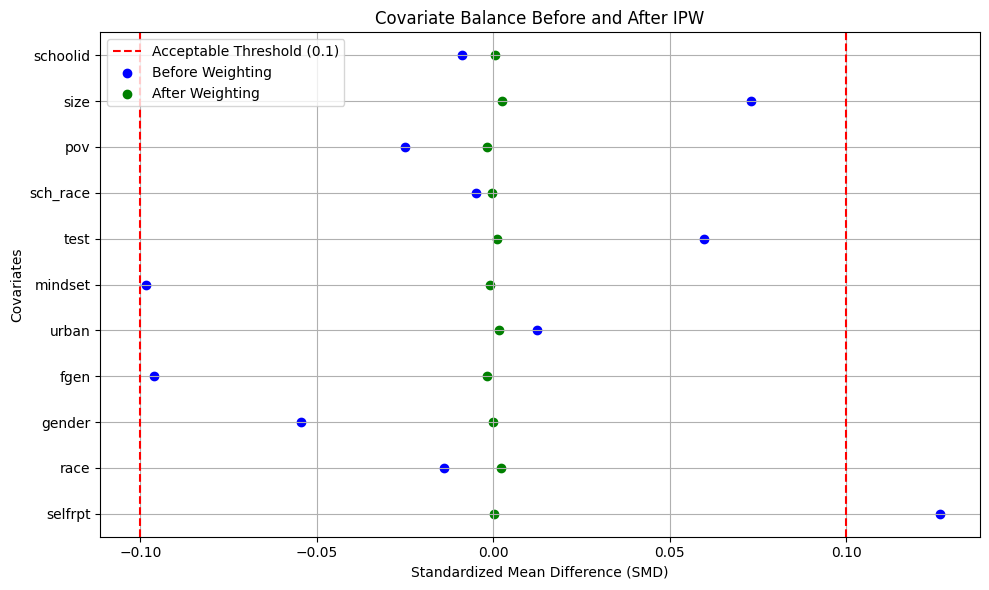

In [ ]:
# Function to compute standardized mean difference (SMD)
def compute_smd(df, covariate, weights=None):
    treated = df[df[treatment] == 1]
    control = df[df[treatment] == 0]

    if weights is not None:
        treat_mean = np.average(treated[covariate], weights=treated[weights])
        control_mean = np.average(control[covariate], weights=control[weights])
        treat_var = np.average((treated[covariate] - treat_mean) ** 2, weights=treated[weights])
        control_var = np.average((control[covariate] - control_mean) ** 2, weights=control[weights])
    else:
        treat_mean = treated[covariate].mean()
        control_mean = control[covariate].mean()
        treat_var = treated[covariate].var()
        control_var = control[covariate].var()

    pooled_std = np.sqrt((treat_var + control_var) / 2)
    return (treat_mean - control_mean) / pooled_std

# Get SMDs
smd_before = [compute_smd(df, cov) for cov in covariates]
smd_after = [compute_smd(df, cov, weights='weights') for cov in covariates]

# Plot
plt.figure(figsize=(10, 6))
plt.axvline(0.1, color='red', linestyle='--', label='Acceptable Threshold (0.1)')
plt.axvline(-0.1, color='red', linestyle='--')

plt.scatter(smd_before, covariates, label='Before Weighting', color='blue')
plt.scatter(smd_after, covariates, label='After Weighting', color='green')

plt.xlabel('Standardized Mean Difference (SMD)')
plt.ylabel('Covariates')
plt.title('Covariate Balance Before and After IPW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Interpretation:**
Green dots (after weighting) close to zero indicate improved covariate balance, which supports causal validity.

## 10. Propensity Score Overlap Check
Verifies the positivity assumption by checking overlap in propensity scores.

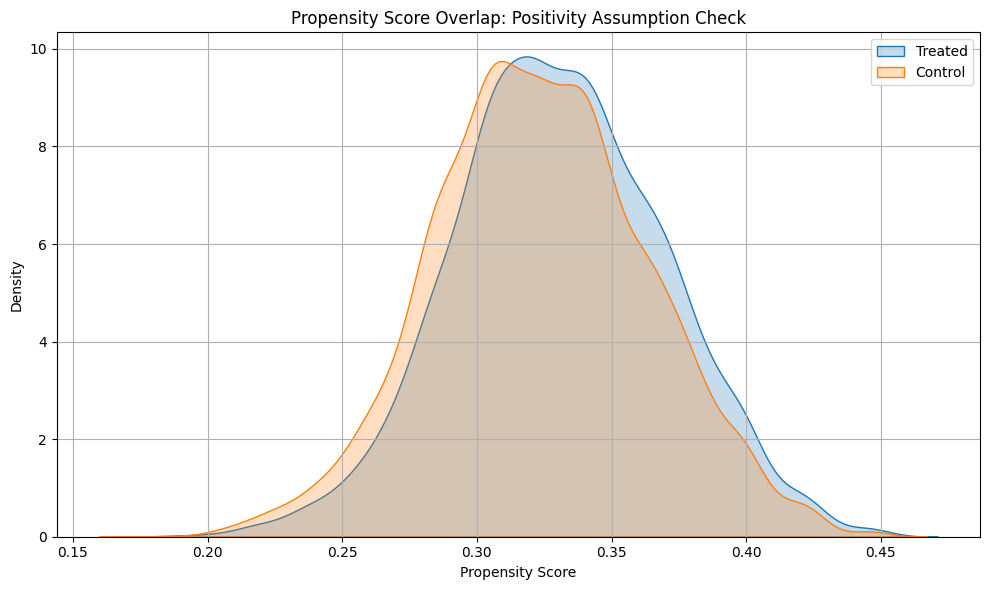

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df[treatment] == 1]['prop_score'], label='Treated', fill=True) # Changed 'propensity_score' to 'prop_score'
sns.kdeplot(df[df[treatment] == 0]['prop_score'], label='Control', fill=True) # Changed 'propensity_score' to 'prop_score'
plt.title('Propensity Score Overlap: Positivity Assumption Check')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:**
Significant overlap between treated and control groups confirms positivity, validating use of propensity-based methods.

## Conclusion:

#### "We assume conditional ignorability, i.e., after controlling for observed covariates, treatment assignment is as good as random. We support this by demonstrating covariate balance post-weighting via standardized mean differences (SMDs). Additionally, we verify the positivity assumption by checking sufficient overlap in propensity scores between treated and control groups."